In [1]:
from SNLDirectional.Energy.FastMixture.fast_mixture_generalized_gaussian_matrix_param import FastMixtureGeneralizedGaussianEnergyMatrix
from SNLDirectional.Proposal import GaussianProposal, UniformProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from SNLDirectional.Trainer import SNLTrainer, EMSNL
from SNLDirectional.Energy import MaxMinTruncation

# Training data 

In [2]:
target_distribution_1 = torch.distributions.Normal(torch.tensor([1,1], dtype=torch.float32) , torch.tensor([2,1], dtype=torch.float32))
target_distribution_2 = torch.distributions.Normal(torch.tensor([-4,-4], dtype=torch.float32) , torch.tensor([2,1], dtype=torch.float32))
cluster_choice = torch.distributions.Categorical(torch.tensor([0.3,0.7]))

In [3]:


sample_choice = cluster_choice.sample((20000,1))
sample_target_cartesian = sample_choice * target_distribution_1.sample((20000,)) + (1-sample_choice) * target_distribution_2.sample((20000,))

truncation = MaxMinTruncation([3,3], [-6,-6])
sample_target_cartesian = truncation.filter(sample_target_cartesian, )




dataset_total = TensorDataset(sample_target_cartesian, )
split_size_train = int(0.8 * len(dataset_total))
split_size_val = int(0.1 * len(dataset_total))
split_size_test = len(dataset_total) - split_size_train - split_size_val
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [split_size_train, split_size_val, split_size_test])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

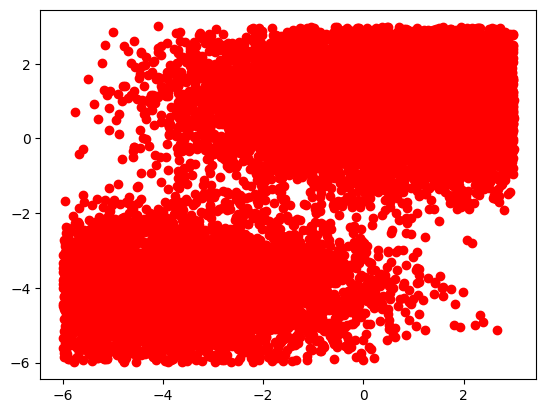

In [4]:


fig = plt.figure()
ax = fig.add_subplot(111)
# Add points
ax.scatter(sample_target_cartesian[...,0], sample_target_cartesian[...,1], color='r')

# Proposal

In [5]:
proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))
proposal_distribution = UniformProposal(torch.Size([2,]), torch.tensor([-6,-6], dtype=torch.float32), torch.tensor([3,3], dtype=torch.float32))

/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_47379/3492471679.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)


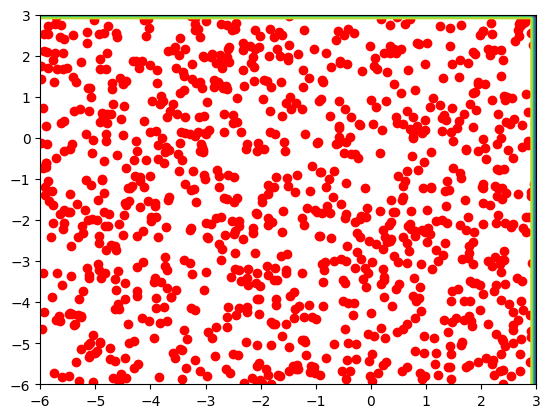

In [6]:
sample_proposal = proposal_distribution.sample(1000,)

fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

# x = np.linspace(-20, 20, 100)
x= np.linspace(-6, 3, 100)
y = np.linspace(-6, 3, 100)
# y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)
Z = proposal_distribution.log_prob(input_grid.flatten(0,1)).exp().numpy().reshape(X.shape)
ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_proposal[...,0], sample_proposal[...,1], color='r')

# Energy

In [7]:
# energy.set_truncator(MaxMinTruncation(min = torch.tensor([-1,-20], dtype=torch.float32), max= torch.tensor([20,20], dtype=torch.float32)))

# Trainer SNL :


In [ ]:

energy = FastMixtureGeneralizedGaussianEnergyMatrix(dim=2, num_cluster=2, learn_mu=True, learn_sigma=True, separate_normalisation=False)
energy.set_truncator(MaxMinTruncation(min = torch.tensor([-6,-6], dtype=torch.float32), max= torch.tensor([3,3], dtype=torch.float32)))
energy.explicit_bias.data = torch.tensor([1.0], dtype=torch.float32)
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val,
                 n_sample_train=1000, n_sample_test=1000, lr=0.01, 
                 name_wandb="GaussianMixture_2D_Truncated_SNL",
                 )

trainer.train(n_iter=10000, n_iter_pretrain=200, log_every=100, plot_every=200., eval_every=100., )

/Users/hhjs/Documents/Projects/SNL_directional/SNLDirectional/Energy/Truncation/abstract_truncation.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.max = torch.tensor(max, dtype=torch.float32)
/Users/hhjs/Documents/Projects/SNL_directional/SNLDirectional/Energy/Truncation/abstract_truncation.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.min = torch.tensor(min, dtype=torch.float32)


SEPARATE NORMALISATION False torch.Size([1])


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hugosenetaire (dtu_prob) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/10200 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 0 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
  2%|▏         | 196/10200 [00:12<02:39, 62.72it/s] wandb: WARNING Tried to log to step 0 that is less than the current step 2. Ste

# Trainer EM :

In [ ]:


energy = FastMixtureGeneralizedGaussianEnergyMatrix(dim=2, num_cluster=2, learn_mu=True, learn_sigma=True, learn_pi=True, separate_normalisation=True, )
energy.set_truncator(MaxMinTruncation(min = torch.tensor([-6,-6], dtype=torch.float32), max= torch.tensor([3,3], dtype=torch.float32)))
energy.explicit_bias.data = torch.tensor([1.0, 1.0], dtype=torch.float32)
trainer = EMSNL(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val,
                 n_sample_train=1000, n_sample_test=1000, lr=0.01, stochastic_em=True
              name_wandb="GaussianMixture_2D_Truncated_EM",
                 )
trainer.train(n_iter=10000, n_iter_pretrain=200, log_every=100, plot_every=200., eval_every=100., max_number_m_step=100,
              )



SEPARATE NORMALISATION True torch.Size([2])


/Users/hhjs/Documents/Projects/SNL_directional/SNLDirectional/Energy/Truncation/abstract_truncation.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.max = torch.tensor(max, dtype=torch.float32)
/Users/hhjs/Documents/Projects/SNL_directional/SNLDirectional/Energy/Truncation/abstract_truncation.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.min = torch.tensor(min, dtype=torch.float32)


TypeError: train() got an unexpected keyword argument 'name_wandb'